In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
import os
import torch.optim as optim
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt
import wandb
from pprint import pprint
import plotly
from torchview import draw_graph
import graphviz
import scipy.io as sio

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

'svg'

## Use Weight and Bias to log the training process 

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = '/home/dylan/repo/VAE/VAE_completement.ipynb'
wandb.login()



wandb: Currently logged in as: dylanheddedly (dylanli). Use `wandb login --relogin` to force relogin


True

In [4]:
def seed_everything(seed: int):
    import random, os

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=3407) #From Torch.manual_seed(3407) is all you need: On the influence of random seeds in deep learning architectures for computer vision

In [5]:
def reparametrization(mu, logvar):

    
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [6]:
def make_physical_data(args, train=True, return_ax=False):
    import scipy.io as sio
    
    #### make pytorch dataset 
    class dataset(Dataset):
        def __init__(self, data, minus_mean=False):
            self.data = data
            self.len = len(data)
            # scale data to float32
            self.data = self.data.astype(np.float32)
            if minus_mean:
                self.data = self.data - self.data.mean(axis=0, keepdims=True)

        def __getitem__(self, idx):
            return self.data[idx], self.data[idx]

        def __len__(self):
            return self.len

    
    data_path = args.data_path + 'physical/'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    data = sio.loadmat(data_path + 'CYLINDER.mat')
        
    U = data['U']
    V = data['V']
    VORTALL = data['VORTALL']
    X = data['X']
    Y = data['Y']
    nx = data['nx'].item()
    ny = data['ny'].item()
    
    if return_ax: 
        return X, Y, nx, ny
    else: 
        # Train test split 
        portion = 0.8
        train_index = int(portion * U.shape[0])
        if train: 
            U_data = U[:train_index, :]
            V_data = V[:train_index, :]
            VORTALL_data = VORTALL[:train_index, :]
        else:
            U_data = U[train_index:, :]
            V_data = V[train_index:, :]
            VORTALL_data = VORTALL[train_index:, :]
        U_data = dataset(U_data)
        V_data = dataset(V_data)
        VORTALL_data = dataset(VORTALL_data)

        
        
        return U_data, V_data, VORTALL_data
    
    

In [7]:
def log_everything(train_loss, val_loss, epoch):
    wandb.log({'loss': train_loss, 'val_loss': val_loss, 'epoch': epoch})

In [8]:
# for downstream classification
class Head(nn.Module):
    def __init__(self, code_dim, out_channels):
        super(Head, self).__init__()
        self.code_dim = code_dim
        self.out_channels = out_channels
        self.hidden = nn.ModuleList()
        for k in range(2):
            self.hidden.append(nn.Linear(code_dim, code_dim, bias=True))
            self.hidden.append(nn.ReLU(True))
            self.hidden.append(nn.Dropout2d(0.5))
        self.hidden.append(nn.Linear(code_dim, out_channels, bias=False))

    def forward(self, z):
        for l in self.hidden:
            z = l(z)
        return z

In [9]:
class InnerMLP(nn.Module):
    def __init__(self, latent_dim, layers):
        super(InnerMLP, self).__init__()
        self.latent_dim = latent_dim
        self.layers = layers
        self.hidden = nn.ModuleList()
        for k in range(layers):
            linear_layer = nn.Linear(latent_dim, latent_dim, bias=False)
            self.hidden.append(linear_layer)

    def forward(self, z):
        for l in self.hidden:
            z = l(z)
        return z

In [10]:
class MNIST_Encoder(nn.Module):
    def __init__(self):
        super(MNIST_Encoder, self).__init__()
        self.dcnn = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(True),
        )
        #self.fc = nn.Linear(256*2*2, self.code_dim)
    def forward(self, z):
          z = self.dcnn(z)
          z = z.view(z.size(0), 256*2*2)
          #z = self.fc(z)
          return z


In [11]:
class MNIST_Decoder(nn.Module):
    def __init__(self, latent_dim,vae=False):
        super(MNIST_Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(self.latent_dim, 8*8*128)
        self.dcnn = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 1, 1, 0),
            nn.Sigmoid() if vae else nn.Tanh()
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 128, 8, 8)
        z = self.dcnn(z)
        return z

In [32]:
class Physical_Encoder(nn.Module):
    def __init__(self, args):
        super(Physical_Encoder, self).__init__()
        if args.model_name == 'linearAE':
            self.mlp = nn.Sequential(
                nn.Linear(250, 128, bias=False),
                nn.Linear(128, 64, bias=False),
            )
        else: 
            self.mlp = nn.Sequential(
                nn.Linear(250, 128),
                nn.ReLU(True),
                nn.Linear(128, 64),
                nn.ReLU(True),
            )
        
    def forward(self, z):
        z = self.mlp(z)
        return z

In [33]:
class Physical_Decoder(nn.Module):
    def __init__(self, args, latent_dim):
        super(Physical_Decoder, self).__init__()
        self.latent_dim = latent_dim
        if args.model_name == 'linearAE':
            self.mlp = nn.Sequential(
                nn.Linear(32, 64, bias=False),
                nn.Linear(64, 128, bias=False),
                nn.Linear(128, 250, bias=False),
            )
        else:
            self.mlp = nn.Sequential(
                nn.Linear(32, 64),
                nn.ReLU(True),
                nn.Linear(64, 128),
                nn.ReLU(True),
                nn.Linear(128, 250),
            )

    def forward(self, z):
        z = self.mlp(z)
        return z
    

In [34]:
class Physical_Final_Latent(nn.Module):
    def __init__(self, args, latent_dim):
        super(Physical_Final_Latent, self).__init__()
        self.latent_dim = latent_dim 
        if args.model_name == 'linearAE':
            self.fc = nn.Linear(64, latent_dim, bias=False)
        else:
            self.fc = nn.Linear(64, latent_dim)
        
    def forward(self, z):
        z = self.fc(z)
        return z

In [35]:
class Image_Final_Latent(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Image_Final_Latent, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(input_dim, latent_dim)

    def forward(self, z):
        z = self.fc(z)
        return z


In [36]:
class AE(nn.Module):
    def __init__(self, args):
        super(AE, self).__init__()
        self.args = args
        self.n = args.n
        self.vae = args.vae
        self.l = args.l
        if args.dataset == "physical": self.final_latent = Physical_Final_Latent(args, args.n)
        else: self.final_latent = Image_Final_Latent(256*2*2, args.n * 2)
        self.post_connect = args.post_connect
        if args.dataset == "mnist":
            if args.vae:
                self.enc = MNIST_Encoder()
                self.final_latent = Image_Final_Latent(256*2*2, args.n * 2)
                self.dec = MNIST_Decoder(args.n, vae=True)
            else:
                self.enc = MNIST_Encoder(args)
                self.dec = MNIST_Decoder(args.n)
        if args.dataset == "physical":
            if args.vae:
                # Todo: add vae for physical
                pass
            else: 
                self.enc = Physical_Encoder(args)
                self.dec = Physical_Decoder(args, args.n)
                
        if args.vae and args.l > 0 and not args.post_connect :
            self.mlp = InnerMLP(args.n * 2, args.l)
        else: self.mlp = InnerMLP(args.n, args.l)

    def encode(self, x):
        _ = self.enc(x)
        z = self.final_latent(_)
        if self.vae:
            if self.l > 0: 
                if self.post_connect:
                    mu = z[:, :self.n]
                    logvar = z[:, self.n:]
                    z_bar = reparametrization(mu, logvar)
                    z_bar = self.mlp(z_bar)
                else: 
                    z = self.mlp(z)
                    mu = z[:, :self.n]
                    logvar = z[:, self.n:]
                    z_bar = reparametrization(mu, logvar)
            else: 
                mu = z[:, :self.n]
                logvar = z[:, self.n:]
                z_bar = reparametrization(mu, logvar)
        elif self.l > 0:
            z_bar = self.mlp(z)
        else:
            z_bar = z
        return z_bar

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        _ = self.enc(x)
        z = self.final_latent(_)
        if self.vae:
            if self.l > 0: 
                if self.post_connect:
                    mu = z[:, :self.n]
                    logvar = z[:, self.n:]
                    z_bar = reparametrization(mu, logvar)
                    z_bar = self.mlp(z_bar)
                else: 
                    z = self.mlp(z)
                    mu = z[:, :self.n]
                    logvar = z[:, self.n:]
                    z_bar = reparametrization(mu, logvar)
            else: 
                mu = z[:, :self.n]
                logvar = z[:, self.n:]
                z_bar = reparametrization(mu, logvar)
        elif self.l > 0:
            z_bar = self.mlp(z)
        else:
            z_bar = z
        x_hat = self.decode(z_bar)
        if self.vae:
            loss = F.binary_cross_entropy(x_hat, x)
            loss -= self.args.beta * torch.mean(
                1 + logvar - mu.pow(2) - logvar.exp()
            )
        else:
            loss = F.mse_loss(x_hat, x)
        
        return loss

In [37]:
def train(args):

    # use gpu ##########################################
    device = torch.device("cuda" if args.gpu else "cpu")

    # dataset ##########################################
    if args.dataset == "mnist":
        data_path = args.data_path + "mnist/"
        if not os.path.exists(data_path):
            os.makedirs(data_path)

        train_set = datasets.MNIST(data_path, train=True,
                                download=True,
                                transform=transforms.Compose([
                                    transforms.Resize([32, 32]),
                                    transforms.ToTensor()]))
        valid_set = datasets.MNIST(data_path, train=False,
                                download=True,
                                transform=transforms.Compose([
                                    transforms.Resize([32, 32]),
                                    transforms.ToTensor()]))
    if args.dataset == "physical":
        data_path = args.data_path + "physical/"
        if not os.path.exists(data_path):
            os.makedirs(data_path)
        U_train_data, V_train_data, VORTALL_train_data= make_physical_data(args, True)
        U_test_data, V_test_data, VORTALL_test_data = make_physical_data(args, False)
        x, y, nx, ny = make_physical_data(args, True, return_ax=True)
        
        if args.train_target == "U":
            train_set = U_train_data 
            valid_set = U_test_data
        elif args.train_target == "V":
            train_set = V_train_data 
            valid_set = V_test_data
        else:
            train_set = VORTALL_train_data 
            valid_set = VORTALL_test_data
        
        

    # dataloader ##########################################

    train_loader = torch.utils.data.DataLoader(
        train_set,
        num_workers=32,
        batch_size=args.batch_size
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_set,
        num_workers=32,
        batch_size=args.batch_size
    )

    # init networks ##########################################

    net = AE(args)
    net.to(device)
    
    wandb.watch(net,log='all',log_freq=20)

    # optimizer ##########################################
    optimizer = optim.AdamW(net.parameters(), args.lr)

    # train ################################################
    save_path = args.checkpoint + "/" + args.dataset + "/"

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for e in range(args.epochs):

        recon_loss = 0
        bar = tqdm(train_loader)

        for yi, _, in bar:
            bar.set_description("Epoch %d" % e)
            net.train()

            optimizer.zero_grad()

            yi = yi.to(device)
            loss = net(yi)
            recon_loss += loss.item()

            loss.backward()
            optimizer.step()

        recon_loss /= len(train_loader)
        if e % 10 == 0:
            print("Epoch " + str(e) + '\ttraining loss = ' + str(recon_loss))

        valid_loss = 0

        for yi, _ in tqdm(valid_loader):
            net.eval()

            yi = yi.to(device)
            eval_loss = net(yi)
            valid_loss += eval_loss.item()

        valid_loss /= len(valid_loader)

        print("Epoch " + str(e) + '\tvalid loss = ' + str(valid_loss))
        
        # wandb log ##########################################
        log_everything(recon_loss, valid_loss, e)
        # save model ##########################################
        torch.save(net.state_dict(), save_path + args.model_name)
        # save onnx model ##########################################
        torch.onnx.export(net, yi, save_path+f"{args.model_name}.onnx")
        wandb.save(save_path+f"{args.model_name}.onnx")
    
    wandb.define_metric("val_loss", summary="min")

        

            



In [38]:
def caculate_FID(args, model_list):
  #todo 
  if args.dataset == "mnist":
    args.data_path = args.data_path + "mnist/"
    if not os.path.exists(args.data_path):
        os.makedirs(args.data_path)

    valid_set = datasets.MNIST(args.data_path, train=False,
                                transform=transforms.Compose([
                                  transforms.Resize([32, 32]),
                                  transforms.ToTensor()]))




In [39]:
def plot_singular(args):

    # dataset ##########################################
    # todo : write a make_data_load function
    if args.dataset == "mnist":
        data_path = args.data_path + "mnist/"
        if not os.path.exists(data_path):
            os.makedirs(data_path)
        test_set = datasets.MNIST(data_path, train=False,
                                  transform=transforms.Compose([
                                     transforms.Resize([32, 32]),
                                     transforms.ToTensor()]))

        test_loader = torch.utils.data.DataLoader(
            test_set,
            num_workers=32,
            batch_size=100
        )    
    if args.dataset == "physical":
        U_train_data, V_train_data, VORTALL_train_data= make_physical_data(args, True)
        U_test_data, V_test_data, VORTALL_test_data = make_physical_data(args, False)
        x, y, nx, ny = make_physical_data(args, True, return_ax=True)
        
        if args.train_target == "U":
            train_set = U_train_data 
            test_set = U_test_data
        elif args.train_target == "V":
            train_set = V_train_data 
            test_set = V_test_data
        else:
            train_set = VORTALL_train_data 
            test_set = VORTALL_test_data

        test_loader = torch.utils.data.DataLoader(
            test_set,
            num_workers=32,
            batch_size=100
        )    
    # load model ##########################################

    plt.figure(figsize=(6, 4))

    net = AE(args)
    net.load_state_dict(torch.load(args.checkpoint + "/" + args.dataset + "/"
                        + args.model_name,
                        map_location=torch.device('cpu')))
    print(f"load model {args.model_name}!")
    net.eval()

    z = []
    for yi, _ in test_loader:
        
        z_hat = net.encode(yi)
        z.append(z_hat)

    z = torch.cat(z, dim=0).data.numpy()

    c = np.cov(z, rowvar=False)
    u, d, v = np.linalg.svd(c)

    d = d / d[0]

    plt.plot(range(args.n), d)

    plt.autoscale(enable=True, axis='y', tight=True)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(0, 1)
    plt.xlim(0, args.n)
    plt.xlabel("Singular Value Rank")
    plt.ylabel("Singular Values")
    plt.title("Singular Values of Covariance Matrix")

    if args.dataset == "shape":
        plt.axvline(x=7, color='k', linestyle='dashed', linewidth=1)

    path = args.save_path + "/" + args.dataset + "/singular/"
    if not os.path.exists(path):
        os.makedirs(path)
        
    wandb.log({f"{args.model_name}_Singular": wandb.Image(plt)})
    
    plt.savefig(args.save_path + "/" + args.dataset + "/singular/" +
                args.model_name + ".png", bbox_inches='tight')
    

    return z

In [40]:
def plot_physical_data(args):
  data_path = args.data_path + 'physical/'
  if not os.path.exists(data_path):
      os.makedirs(data_path)
  data = sio.loadmat(data_path + 'CYLINDER.mat')
  latent_save_path = args.checkpoint + "/" + args.dataset + "/latent_space/"
  if not os.path.exists(latent_save_path):
    os.makedirs(latent_save_path)
    
      
  U = data['U']
  V = data['V']
  VORTALL = data['VORTALL']
  X = data['X']
  Y = data['Y']
  nx = data['nx'].item()
  ny = data['ny'].item()
  z = np.load(latent_save_path+f'{args.model_name}_{args.train_target}_z.npy')
  if z.shape[1] < 5:
    num = int(z.shape[1])
  else: num = 5
  r = range(num)
  fig, axs = plt.subplots(nrows=num, ncols=1, figsize=(num*2,num*4))
  if int(z.shape[1]) == 1:
    axs = [axs]
  else: axs = axs.flatten()
  idx = 0
  for i in r:
    pcm = axs[idx].pcolormesh(X,Y,z[:,i].reshape(nx,ny).T,cmap = 'RdBu_r')
    fig.colorbar(pcm,ax=axs[idx])
    axs[idx].set_title(f'{args.model_name} mode {i+1} for $v$ velocity')
    axs[idx].set_aspect('equal')
    axs[idx].set_xlabel('x', fontsize = 14)
    axs[idx].set_ylabel('y',fontsize = 14)
    idx += 1
  fig.tight_layout()
  wandb.log({f'{args.model_name}_{args.train_target}_reconstructed': wandb.Image(fig)})
  # Clear the current figure
  plt.clf()

In [41]:
def calculate_latent_space(args):
    #### Load saved model 
    net = AE(args)
    net.load_state_dict(torch.load(args.checkpoint + "/" + args.dataset + "/"
                        + args.model_name,
                        map_location=torch.device('cpu')))
    print(f"load model {args.model_name}_{args.train_target}!")
    net.eval()
    
    #### Saved Path
    latent_save_path = args.checkpoint + "/" + args.dataset + "/latent_space/"
    if not os.path.exists(latent_save_path):
        os.makedirs(latent_save_path)
    
    #### Load whole data
    if args.dataset == 'physical':
        data_path = args.data_path + 'physical/'
        if not os.path.exists(data_path):
            os.makedirs(data_path)
        data = sio.loadmat(data_path + 'CYLINDER.mat')
            
        U = data['U']
        V = data['V']
        VORTALL = data['VORTALL']
        X = data['X']
        Y = data['Y']
        nx = data['nx'].item()
        ny = data['ny'].item()
        if args.train_target == 'U':
            _ = U
        elif args.train_target == 'V':
            _ = V
        elif args.train_target == 'VORTALL':
            _ = VORTALL
        else:
            raise ValueError("train_target should be U, V or VORTALL")

        z = net.encode(torch.tensor(_.astype(np.float32)))
        np.save(latent_save_path+f'{args.model_name}_{args.train_target}_z.npy', z.detach().numpy())
    # todoL: add other dataset
        

In [42]:
def main(args):
    with wandb.init(project=args.wandb_project, config=args, name=args.wandb_run_name, notes="This is a baseline for the project", tags=['baseline'], save_code=True) as run:
        pprint(AE(args))
        train(args)
        plot_singular(args)
        calculate_latent_space(args)
        plot_physical_data(args)
    

In [43]:

class Config:
  def __init__(self):
    self.l = 0
    self.lr = 0.0001
    self.epochs = 100
    self.vae = True
    self.n = 128
    self.batch_size = 128
    self.dataset = 'mnist'
    self.data_path = './data/'
    self.checkpoint = './checkpoint/'
    self.gpu = torch.cuda.is_available()
    self.beta = 0.1
    self.model_name = 'VAE'
    self.wandb_run_name = ''
    self.save_path = './results/'
    self.post_connect = False
    self.wandb_project = '10617-project'
    self.train_target = 'U'
    
  def __str__(self):
        attributes = ["{}={}".format(attr, value) for attr, value in vars(self).items()]
        return "Config({})".format(", ".join(attributes))
  
  def __repr__(self):
      return self.__str__()



### Linear Autoencoder 

In [48]:
args_linear = Config()
args_linear.model_name = "linearAE"
args_linear.vae = False
args_linear.l = 0
args_linear.lr = 0.001
args_linear.epochs = 50
args_linear.post_connect = False
args_linear.dataset = "physical"
args_linear.train_target = "U"
args_linear.wandb_run_name = "linearAE"
args_linear.n = 32

In [49]:
pprint(args_linear)

Config(l=0, lr=0.001, epochs=50, vae=False, n=32, batch_size=128, dataset=physical, data_path=./data/, checkpoint=./checkpoint/, gpu=True, beta=0.1, model_name=linearAE, wandb_run_name=linearAE, save_path=./results/, post_connect=False, wandb_project=10617-project, train_target=U)


AE(
  (final_latent): Physical_Final_Latent(
    (fc): Linear(in_features=64, out_features=32, bias=False)
  )
  (enc): Physical_Encoder(
    (mlp): Sequential(
      (0): Linear(in_features=250, out_features=128, bias=False)
      (1): Linear(in_features=128, out_features=64, bias=False)
    )
  )
  (dec): Physical_Decoder(
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=False)
      (1): Linear(in_features=64, out_features=128, bias=False)
      (2): Linear(in_features=128, out_features=250, bias=False)
    )
  )
  (mlp): InnerMLP(
    (hidden): ModuleList()
  )
)


Epoch 0: 100%|██████████| 786/786 [00:04<00:00, 180.31it/s]


Epoch 0	training loss = 0.011450156039530136


100%|██████████| 197/197 [00:02<00:00, 74.52it/s] 


Epoch 0	valid loss = 0.0010094533412632186


100%|██████████| 197/197 [00:02<00:00, 75.47it/s] 


Epoch 1	valid loss = 0.0010594761629617267


100%|██████████| 197/197 [00:02<00:00, 75.60it/s] 


Epoch 2	valid loss = 0.0005010133448883012


100%|██████████| 197/197 [00:02<00:00, 78.09it/s] 


Epoch 3	valid loss = 0.00043844503430628365


100%|██████████| 197/197 [00:02<00:00, 76.08it/s] 
/home/dylan/mambaforge/envs/aiml/lib/python3.10/site-packages/wandb/wandb_torch.py:287: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tensor.shape == torch.Size([0]) or (~torch.isfinite(tensor)).all().item()
/home/dylan/mambaforge/envs/aiml/lib/python3.10/site-packages/wandb/wandb_torch.py:287: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tensor.shape == torch.Size([0]) or (~torch.isfinite(tensor)).all().item()
/home/dylan/mambaforge/envs/aiml/lib/python3.10/site-packages/wandb/wandb_torc

Epoch 4	valid loss = 0.0004815324813498038


100%|██████████| 197/197 [00:02<00:00, 77.39it/s] 


Epoch 5	valid loss = 0.000628868405827437


100%|██████████| 197/197 [00:02<00:00, 76.56it/s] 


Epoch 6	valid loss = 0.0004518695157845646


100%|██████████| 197/197 [00:02<00:00, 75.62it/s] 


Epoch 7	valid loss = 0.0004944284581715184


100%|██████████| 197/197 [00:02<00:00, 75.62it/s] 


Epoch 8	valid loss = 0.0006516920454722716


100%|██████████| 197/197 [00:02<00:00, 77.38it/s] 


Epoch 9	valid loss = 0.0005475960792379742


Epoch 10: 100%|██████████| 786/786 [00:04<00:00, 181.39it/s]


Epoch 10	training loss = 0.00014296787040990466


100%|██████████| 197/197 [00:02<00:00, 75.88it/s] 


Epoch 10	valid loss = 0.0006717238554537183


100%|██████████| 197/197 [00:02<00:00, 76.57it/s] 


Epoch 11	valid loss = 0.0007231074193215381


100%|██████████| 197/197 [00:02<00:00, 76.37it/s] 


Epoch 12	valid loss = 0.0008661378207004885


100%|██████████| 197/197 [00:02<00:00, 76.59it/s] 


Epoch 13	valid loss = 0.0008290146472275867


100%|██████████| 197/197 [00:02<00:00, 74.57it/s] 


Epoch 14	valid loss = 0.0009835045954053288


100%|██████████| 197/197 [00:02<00:00, 75.61it/s] 


Epoch 15	valid loss = 0.0006212356639863464


100%|██████████| 197/197 [00:02<00:00, 74.86it/s] 


Epoch 16	valid loss = 0.0008146054698151376


100%|██████████| 197/197 [00:02<00:00, 76.22it/s] 


Epoch 17	valid loss = 0.0008242602538681462


100%|██████████| 197/197 [00:02<00:00, 76.61it/s] 


Epoch 18	valid loss = 0.0007712292682313298


100%|██████████| 197/197 [00:02<00:00, 76.37it/s] 


Epoch 19	valid loss = 0.0006694765884484174


Epoch 20: 100%|██████████| 786/786 [00:04<00:00, 177.11it/s]


Epoch 20	training loss = 0.00010065010506864574


100%|██████████| 197/197 [00:02<00:00, 75.29it/s] 


Epoch 20	valid loss = 0.0008207328727930964


100%|██████████| 197/197 [00:02<00:00, 73.62it/s] 


Epoch 21	valid loss = 0.0007897356968195187


100%|██████████| 197/197 [00:02<00:00, 74.88it/s] 


Epoch 22	valid loss = 0.0008135680538063826


100%|██████████| 197/197 [00:02<00:00, 75.94it/s] 


Epoch 23	valid loss = 0.000719586947488452


100%|██████████| 197/197 [00:02<00:00, 75.38it/s] 


Epoch 24	valid loss = 0.0008405251938909963


100%|██████████| 197/197 [00:02<00:00, 74.76it/s] 


Epoch 25	valid loss = 0.0006248134180671786


100%|██████████| 197/197 [00:02<00:00, 76.17it/s] 


Epoch 26	valid loss = 0.0006528979668238313


100%|██████████| 197/197 [00:02<00:00, 74.57it/s] 


Epoch 27	valid loss = 0.000668180447142999


100%|██████████| 197/197 [00:02<00:00, 75.01it/s] 


Epoch 28	valid loss = 0.00075843889113125


100%|██████████| 197/197 [00:02<00:00, 76.47it/s] 


Epoch 29	valid loss = 0.0006641412586630274


Epoch 30: 100%|██████████| 786/786 [00:04<00:00, 176.40it/s]


Epoch 30	training loss = 0.00041819695176219186


100%|██████████| 197/197 [00:02<00:00, 75.13it/s] 


Epoch 30	valid loss = 0.0005753541040691655


100%|██████████| 197/197 [00:02<00:00, 74.70it/s] 


Epoch 31	valid loss = 0.000855010679921816


100%|██████████| 197/197 [00:02<00:00, 74.74it/s] 


Epoch 32	valid loss = 0.0006256915255804867


100%|██████████| 197/197 [00:02<00:00, 76.35it/s] 


Epoch 33	valid loss = 0.0008455457751311807


100%|██████████| 197/197 [00:02<00:00, 76.08it/s] 


Epoch 34	valid loss = 0.000978721335570465


100%|██████████| 197/197 [00:02<00:00, 75.26it/s] 


Epoch 35	valid loss = 0.0010493415802880308


100%|██████████| 197/197 [00:02<00:00, 74.66it/s] 


Epoch 36	valid loss = 0.0009313242125184852


100%|██████████| 197/197 [00:02<00:00, 74.97it/s] 


Epoch 37	valid loss = 0.0008987626162780741


100%|██████████| 197/197 [00:02<00:00, 75.91it/s] 


Epoch 38	valid loss = 0.0007071689394210184


100%|██████████| 197/197 [00:02<00:00, 75.89it/s] 


Epoch 39	valid loss = 0.000872380941450155


Epoch 40: 100%|██████████| 786/786 [00:04<00:00, 178.57it/s]


Epoch 40	training loss = 0.00020226417962976136


100%|██████████| 197/197 [00:02<00:00, 76.18it/s] 


Epoch 40	valid loss = 0.0011346899300036883


100%|██████████| 197/197 [00:02<00:00, 74.12it/s] 


Epoch 41	valid loss = 0.00091814575812881


100%|██████████| 197/197 [00:02<00:00, 74.80it/s] 


Epoch 42	valid loss = 0.0010858432175653637


100%|██████████| 197/197 [00:02<00:00, 76.56it/s] 


Epoch 43	valid loss = 0.0011176964496930133


100%|██████████| 197/197 [00:02<00:00, 75.77it/s] 


Epoch 44	valid loss = 0.0009038296832051837


100%|██████████| 197/197 [00:02<00:00, 75.12it/s] 


Epoch 45	valid loss = 0.0008653109339343592


100%|██████████| 197/197 [00:02<00:00, 76.85it/s] 


Epoch 46	valid loss = 0.0005415563681694741


100%|██████████| 197/197 [00:02<00:00, 75.42it/s] 


Epoch 47	valid loss = 0.0009544211542131888


100%|██████████| 197/197 [00:02<00:00, 70.91it/s] 


Epoch 48	valid loss = 0.0008045432394486261


100%|██████████| 197/197 [00:02<00:00, 77.23it/s] 


Epoch 49	valid loss = 0.0008726392336980721
load model linearAE!
load model linearAE_U!


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▁▁▃▁▁▁▂▁▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▂▁▃▁▂▃▃▄▅▅▃▅▅▄▅▅▅▄▃▃▃▄▂▅▃▅▇▆▆▄█▆██▅▂▆▅
epoch,49
loss,0.00011
val_loss,0.00087


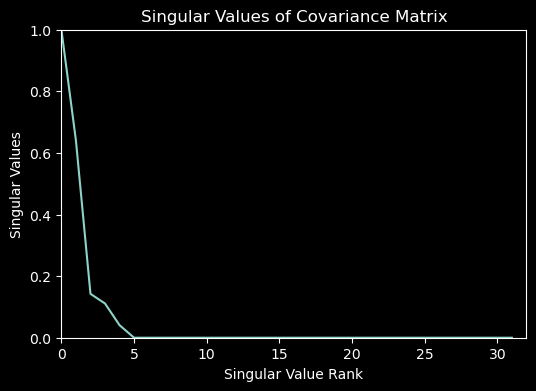

<Figure size 1000x2000 with 0 Axes>

In [50]:
main(args_linear)

### No linear autoencoder

In [54]:
args_AE = Config()
args_AE.model_name = "nolinearAE"
args_AE.vae = False
args_AE.l = 0
args_AE.lr = 0.001
args_AE.epochs = 50
args_AE.post_connect = False
args_AE.dataset = "physical"
args_AE.train_target = "U"
args_AE.wandb_run_name = "nolinearAE" + '_' + args_AE.train_target
args_AE.n = 32

In [55]:
pprint(args_AE)

Config(l=0, lr=0.001, epochs=50, vae=False, n=32, batch_size=128, dataset=physical, data_path=./data/, checkpoint=./checkpoint/, gpu=True, beta=0.1, model_name=nolinearAE, wandb_run_name=nolinearAE_U, save_path=./results/, post_connect=False, wandb_project=10617-project, train_target=U)


AE(
  (final_latent): Physical_Final_Latent(
    (fc): Linear(in_features=64, out_features=32, bias=True)
  )
  (enc): Physical_Encoder(
    (mlp): Sequential(
      (0): Linear(in_features=250, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (dec): Physical_Decoder(
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=128, out_features=250, bias=True)
    )
  )
  (mlp): InnerMLP(
    (hidden): ModuleList()
  )
)


Epoch 0: 100%|██████████| 786/786 [00:04<00:00, 167.81it/s]


Epoch 0	training loss = 0.016549957165532033


100%|██████████| 197/197 [00:02<00:00, 74.91it/s] 


Epoch 0	valid loss = 0.002206521572044053


100%|██████████| 197/197 [00:02<00:00, 75.21it/s] 


Epoch 1	valid loss = 0.0027819681563414633


100%|██████████| 197/197 [00:02<00:00, 75.50it/s] 


Epoch 2	valid loss = 0.0023639234870809324


100%|██████████| 197/197 [00:02<00:00, 74.93it/s] 


Epoch 3	valid loss = 0.0010551857627008753


100%|██████████| 197/197 [00:02<00:00, 74.51it/s] 
/home/dylan/mambaforge/envs/aiml/lib/python3.10/site-packages/wandb/wandb_torch.py:287: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tensor.shape == torch.Size([0]) or (~torch.isfinite(tensor)).all().item()
/home/dylan/mambaforge/envs/aiml/lib/python3.10/site-packages/wandb/wandb_torch.py:287: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tensor.shape == torch.Size([0]) or (~torch.isfinite(tensor)).all().item()
/home/dylan/mambaforge/envs/aiml/lib/python3.10/site-packages/wandb/wandb_torc

Epoch 4	valid loss = 0.0017586231653768862


100%|██████████| 197/197 [00:02<00:00, 75.35it/s] 


Epoch 5	valid loss = 0.0010024571482081506


100%|██████████| 197/197 [00:02<00:00, 74.00it/s] 


Epoch 6	valid loss = 0.0007560645835237757


100%|██████████| 197/197 [00:02<00:00, 74.47it/s] 


Epoch 7	valid loss = 0.0004872538109172873


100%|██████████| 197/197 [00:02<00:00, 73.84it/s]


Epoch 8	valid loss = 0.0007819345652014678


100%|██████████| 197/197 [00:02<00:00, 74.43it/s] 


Epoch 9	valid loss = 0.0009446527549186202


Epoch 10: 100%|██████████| 786/786 [00:04<00:00, 162.43it/s]


Epoch 10	training loss = 0.00045003566957352715


100%|██████████| 197/197 [00:02<00:00, 74.85it/s] 


Epoch 10	valid loss = 0.0010333736899142214


100%|██████████| 197/197 [00:02<00:00, 74.36it/s] 


Epoch 11	valid loss = 0.0010432363210776633


  1%|          | 1/197 [02:42<8:50:55, 162.53s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f226c750ee0>
Traceback (most recent call last):
  File "/home/dylan/mambaforge/envs/aiml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/dylan/mambaforge/envs/aiml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/home/dylan/mambaforge/envs/aiml/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f226c750ee0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f226c750ee0>Traceback (most recent call last):

  File "/home/dylan/mambaforge/envs/aiml/lib/python3.10/site-packages/t

Epoch 12	valid loss = 0.0010894320820704064


100%|██████████| 197/197 [00:02<00:00, 76.25it/s] 


Epoch 13	valid loss = 0.0007999235252095717


100%|██████████| 197/197 [00:02<00:00, 77.71it/s] 


Epoch 14	valid loss = 0.0011077739054137406


100%|██████████| 197/197 [00:02<00:00, 76.80it/s] 


Epoch 15	valid loss = 0.0008346084373281278


100%|██████████| 197/197 [00:02<00:00, 76.80it/s] 


Epoch 16	valid loss = 0.001085956430837966


100%|██████████| 197/197 [00:02<00:00, 76.78it/s] 


Epoch 17	valid loss = 0.0005830239490836358


100%|██████████| 197/197 [00:02<00:00, 76.49it/s]


Epoch 18	valid loss = 0.0010623599813014818


100%|██████████| 197/197 [00:02<00:00, 74.63it/s] 


Epoch 19	valid loss = 0.0006416169057841304


Epoch 20: 100%|██████████| 786/786 [00:04<00:00, 169.40it/s]


Epoch 20	training loss = 0.00023570094115303518


100%|██████████| 197/197 [00:02<00:00, 76.03it/s] 


Epoch 20	valid loss = 0.0009218537485638284


100%|██████████| 197/197 [00:02<00:00, 76.45it/s] 


Epoch 21	valid loss = 0.0009279241344602223


100%|██████████| 197/197 [00:02<00:00, 74.46it/s] 


Epoch 22	valid loss = 0.0006490143719274045


100%|██████████| 197/197 [00:02<00:00, 75.26it/s] 


Epoch 23	valid loss = 0.0007776609675643781


100%|██████████| 197/197 [00:02<00:00, 76.24it/s] 


Epoch 24	valid loss = 0.0006623676557043334


100%|██████████| 197/197 [00:02<00:00, 76.87it/s] 


Epoch 25	valid loss = 0.000681485048281608


100%|██████████| 197/197 [00:02<00:00, 76.88it/s] 


Epoch 26	valid loss = 0.0007800288048326416


100%|██████████| 197/197 [00:02<00:00, 75.97it/s] 


Epoch 27	valid loss = 0.0008676950559776446


100%|██████████| 197/197 [00:02<00:00, 75.98it/s] 


Epoch 28	valid loss = 0.0006945630664419238


100%|██████████| 197/197 [00:02<00:00, 77.41it/s] 


Epoch 29	valid loss = 0.0008677641731244571


Epoch 30: 100%|██████████| 786/786 [00:04<00:00, 160.51it/s]


Epoch 30	training loss = 0.00014992893007867132


100%|██████████| 197/197 [00:02<00:00, 75.09it/s] 


Epoch 30	valid loss = 0.0007352260468296616


100%|██████████| 197/197 [00:02<00:00, 75.85it/s] 


Epoch 31	valid loss = 0.0006586374297397103


100%|██████████| 197/197 [00:02<00:00, 76.08it/s] 


Epoch 32	valid loss = 0.0007648112246149744


100%|██████████| 197/197 [00:02<00:00, 75.23it/s] 


Epoch 33	valid loss = 0.0007890459776620811


100%|██████████| 197/197 [00:02<00:00, 76.27it/s] 


Epoch 34	valid loss = 0.0005225858851725964


100%|██████████| 197/197 [00:02<00:00, 75.13it/s] 


Epoch 35	valid loss = 0.0006898939409715757


100%|██████████| 197/197 [00:02<00:00, 76.33it/s] 


Epoch 36	valid loss = 0.000815665000339918


100%|██████████| 197/197 [00:02<00:00, 76.71it/s] 


Epoch 37	valid loss = 0.0005712721299667852


100%|██████████| 197/197 [00:02<00:00, 75.45it/s]


Epoch 38	valid loss = 0.0006345538339918293


100%|██████████| 197/197 [00:02<00:00, 75.40it/s] 


Epoch 39	valid loss = 0.0009290110571741311


Epoch 40: 100%|██████████| 786/786 [00:04<00:00, 163.30it/s]


Epoch 40	training loss = 0.0001553641558696263


100%|██████████| 197/197 [00:02<00:00, 75.11it/s]


Epoch 40	valid loss = 0.000718399956978256


100%|██████████| 197/197 [00:02<00:00, 75.65it/s] 


Epoch 41	valid loss = 0.0004956599597956248


100%|██████████| 197/197 [00:02<00:00, 76.09it/s]


Epoch 42	valid loss = 0.0008216776582161272


100%|██████████| 197/197 [00:02<00:00, 76.56it/s] 


Epoch 43	valid loss = 0.0005709239175935573


100%|██████████| 197/197 [00:02<00:00, 75.20it/s] 


Epoch 44	valid loss = 0.0006205459107759499


100%|██████████| 197/197 [00:02<00:00, 74.27it/s]


Epoch 45	valid loss = 0.0005628504245739955


100%|██████████| 197/197 [00:02<00:00, 74.72it/s] 


Epoch 46	valid loss = 0.0010505040053001647


100%|██████████| 197/197 [00:02<00:00, 75.77it/s] 


Epoch 47	valid loss = 0.0007058665565627823


100%|██████████| 197/197 [00:02<00:00, 75.95it/s] 


Epoch 48	valid loss = 0.0007643770804492223


100%|██████████| 197/197 [00:02<00:00, 75.62it/s] 


Epoch 49	valid loss = 0.000578735931329565
load model nolinearAE!
load model nolinearAE_U!


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▇▃▃▂▁▂▃▃▃▂▂▃▁▃▂▂▁▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▃▂▁
epoch,49
loss,0.00012
val_loss,0.00058


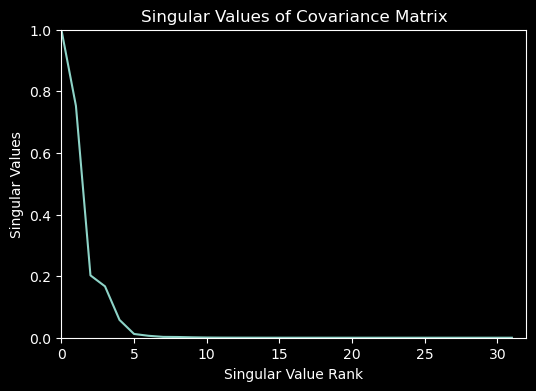

<Figure size 1000x2000 with 0 Axes>

In [56]:
main(args_AE)